## Analysis of the created network graph

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import spearmanr


In [2]:
# Read in a saved graph 
Graph = nx.read_gpickle('Network_Graph.gpickle')

# Number of edges
print('Number of nodes:', len(Graph.nodes))

# Number of edges
print('Number of edges:', len(Graph.edges))

# Density
print('Density of the graph:', nx.density(Graph))

numNodes = len(Graph.nodes)


Number of nodes: 3000
Number of edges: 60559
Density of the graph: 0.006731021451594976


In [3]:
# Translate the graph into a matrix

#       To
#       ___
#      |0
# From | 0
#      |  0

M = nx.to_numpy_matrix(Graph)

# Multiply with the transpose to find reciprocal edges
Reciprocal = nx.from_numpy_matrix(np.multiply(M,(M.T)), create_using=nx.DiGraph())

# Re-numerate the nodes of the reciprocal graph
mapping = {i: Graph for i, Graph in enumerate(list(Graph.nodes()))}
Reciprocal = nx.relabel_nodes(Reciprocal, mapping)

# List of reciprocal edges
reciprocal_edges = list(Reciprocal.edges)


In [4]:
# Save the node information for the graph in a dataframe
degrees = pd.concat([pd.Series(dict(Graph.in_degree()), name='in'), 
                     pd.Series(dict(Graph.out_degree()), name='out'),
                     pd.Series(dict(Reciprocal.in_degree()), name='reciprocal'),
                     pd.Series(pd.Series(dict(Graph.in_degree()))+pd.Series(dict(Graph.out_degree())), name='total')], 
                     axis=1)

# Directed degree for every node
directed_degree = []

for i in range(numNodes):
    directed_degree.append(degrees['total'].iloc[i] - 2 * degrees['reciprocal'].iloc[i])
    
degrees['directed'] = directed_degree


In [5]:
# The only in degree (reciprocal degree is subtrated)
degrees['only_in'] = list(degrees['in'] - degrees['reciprocal'])

# The only out degree (reciprocal degree is subtrated)
degrees['only_out'] = list(degrees['out'] - degrees['reciprocal'])

# Number of neighbors
degrees['Ne'] = degrees['total'] - degrees['reciprocal']


In [6]:
# Clustering in the whole graph
Clustering = []

for i in range(numNodes):
    Clustering.append(nx.clustering(Graph, list(Graph.nodes)[i]))

degrees['clustering'] = Clustering


In [7]:
# Correlation between the distributions of the actual data
Rho_1 = spearmanr(degrees['reciprocal'],degrees['only_in'])[0]
Rho_2 = spearmanr(degrees['reciprocal'],degrees['only_out'])[0]
Rho_3 = spearmanr(degrees['only_in'],degrees['only_out'])[0]

print(Rho_1, Rho_2, Rho_3)


0.5454656868986052 0.46121423842812725 0.35178204005275765


### Topological graph features

Strongly connected components

In [8]:
# strongly_connected_components
df_strong = pd.DataFrame()
d = {}
indices = []

components = [C for C in nx.algorithms.components.strongly_connected_components(Graph)]
m = pd.Series([len(c) for c in components], name='Graph')
df_strong = pd.concat([df_strong, m.describe()], axis=1)    
d['Graph'] = m.value_counts()
round(df_strong, 2)


,Graph
count,676.00
mean,4.44
std,89.38
min,1.00
25%,1.00
50%,1.00
75%,1.00
max,2325.00


In [9]:
# strongly_connected_components
indices = sorted(list(set([item for sublist in [list(v.index) for v in d.values()] for item in sublist])))
df_strong = pd.DataFrame(index=sorted(indices))
for k, v in d.items():
    df_strong = df_strong.join(v, how='outer')
df_strong = df_strong.fillna(0).astype(int)
df_strong = pd.concat([df_strong, pd.DataFrame(df_strong.sum(axis=0)).T])
df_strong.index.name = '#nodes'
df_strong


,Graph
#nodes,
1,675
2325,1
0,676


Weakly Connected Components

In [10]:
# weakly connected components
df_weak = pd.DataFrame()
d = {}
indices = []
 
components = [C for C in nx.algorithms.components.weakly_connected_components(Graph)]
m = pd.Series([len(c) for c in components], name='Graph')
df_weak = pd.concat([df_weak, m.describe()], axis=1)    
d['Graph'] = m.value_counts()
round(df_weak, 2)


,Graph
count,285.00
mean,10.53
std,160.82
min,1.00
25%,1.00
50%,1.00
75%,1.00
max,2716.00


In [11]:
# weakly_connected_components
indices = sorted(list(set([item for sublist in [list(v.index) for v in d.values()] for item in sublist])))
df_weak = pd.DataFrame(index=sorted(indices))
for k, v in d.items():
    df_weak = df_weak.join(v, how='outer')
df_weak = df_weak.fillna(0).astype(int)
df_weak = pd.concat([df_weak, pd.DataFrame(df_weak.sum(axis=0)).T])
df_weak.index.name = '#nodes'
df_weak


,Graph
#nodes,
1,284
2716,1
0,285


In [12]:
# Keep only the largest weakly connected component of the generated graph
Graph_weak = Graph.subgraph(components[np.argmax([len(i) for i in components])])


In [13]:
# Density
print('Density:', nx.density(Graph_weak))


Density: 0.008212570213481532


In [14]:
# Average shortest path length
average_shortest_path_length = nx.average_shortest_path_length(Graph_weak)

print('Average shortest path length:', average_shortest_path_length)


Average shortest path length: 2.4986144449236094


In [15]:
# Clustering Coefficients
clustering_coeff = nx.average_clustering(Graph_weak)

print('Average clustering coefficient:', clustering_coeff)


Average clustering coefficient: 0.33550438074938044


In [16]:
# Diameter
G = Graph_weak.to_undirected()#.subgraph(components[np.argmax([len(i) for i in components])])

diameter = nx.diameter(G)
print('Diameter:', diameter)


Diameter: 4


In [17]:
degrees['only_in'] = degrees['in']-degrees['reciprocal']
degrees['only_out'] = degrees['out']-degrees['reciprocal']

# Correlation between the distributions of the created graphs

Rho_1 = spearmanr(degrees['reciprocal'],degrees['only_in'])[0]
Rho_2 = spearmanr(degrees['reciprocal'],degrees['only_out'])[0]
Rho_3 = spearmanr(degrees['only_in'],degrees['only_out'])[0]

print(Rho_1)
print(Rho_2)
print(Rho_3)


0.5454656868986052
0.46121423842812725
0.35178204005275765


### Various plots

In [18]:
mean_clustering = np.mean(degrees['clustering'])


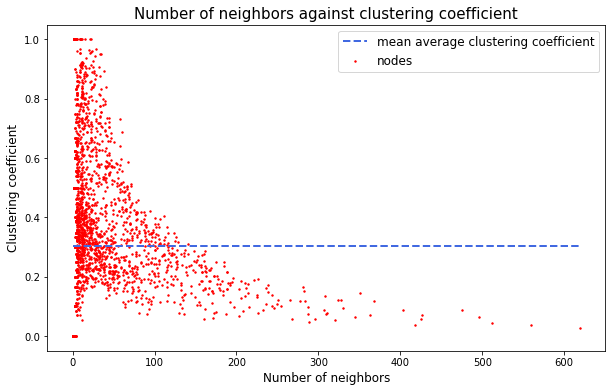

In [19]:
plt.figure(figsize=(10,6))

plt.scatter(degrees['Ne'], degrees['clustering'], s=2, label='nodes', c='red')
plt.plot([0, max(degrees['Ne'])], [mean_clustering, mean_clustering], lw=2, linestyle='dashed', c='royalblue', label='mean average clustering coefficient')

plt.xlabel('Number of neighbors', fontsize=12)
plt.ylabel('Clustering coefficient', fontsize=12)
plt.title('Number of neighbors against clustering coefficient', fontsize=15)

plt.legend(prop={'size': 12})
plt.show()


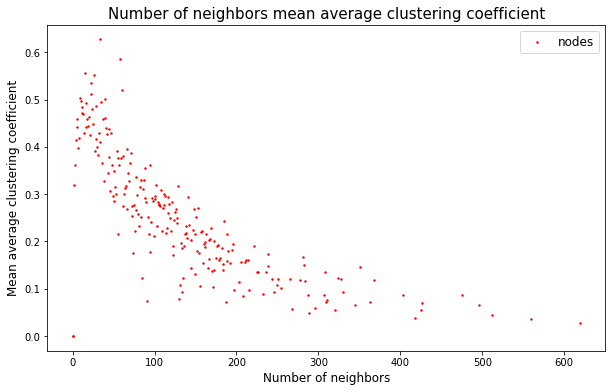

In [20]:
plt.figure(figsize=(10,6))

for i in range(1, max(degrees['Ne'])+1):
    g = np.mean(degrees[degrees['Ne'] == i]['clustering'])
    plt.scatter(i, g, s=2, c='red')
    
plt.scatter(0, 0, s=2, label='nodes', c='red')

plt.xlabel('Number of neighbors', fontsize=12)
plt.ylabel('Mean average clustering coefficient', fontsize=12)
plt.title('Number of neighbors mean average clustering coefficient', fontsize=15)

plt.legend(prop={'size': 12})
plt.show()



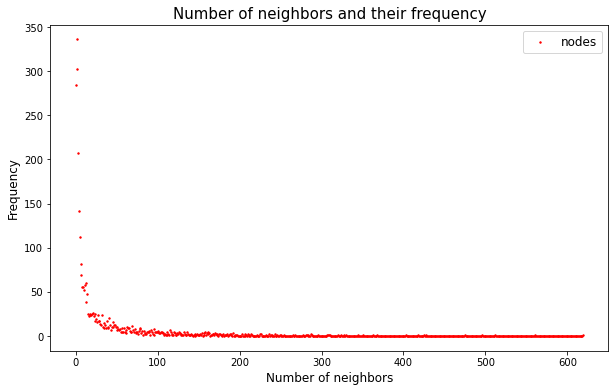

In [21]:
plt.figure(figsize=(10,6))

for i in range(1, max(degrees['Ne'])+1):
    g = degrees[degrees['Ne'] == i].shape[0]
    plt.scatter(i, g, s=2, c='red')

n = degrees[degrees['Ne'] == 0].shape[0]
plt.scatter(0, n, s=2, label='nodes', c='red')

plt.xlabel('Number of neighbors', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Number of neighbors and their frequency', fontsize=15)

plt.legend(prop={'size': 12})
plt.show()


3D plots of the node degrees

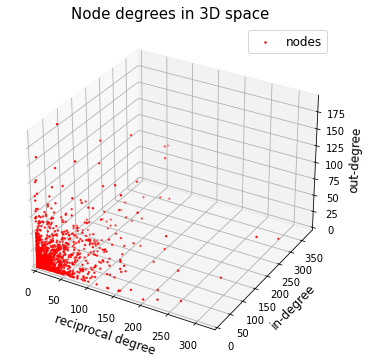

In [22]:
# 3D plot
%matplotlib inline
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

ax.scatter3D(degrees['reciprocal'], degrees['only_in'], degrees['only_out'], c='red', s=2, label='nodes')

ax.set_xlim3d(0, max(degrees['reciprocal']))
ax.set_ylim3d(0, max(degrees['only_in']))
ax.set_zlim3d(0, max(degrees['only_out']))

ax.set_xlabel('reciprocal degree', fontsize=12)
ax.set_ylabel('in-degree', fontsize=12)
ax.set_zlabel('out-degree', fontsize=12)
ax.set_title('Node degrees in 3D space', fontsize=15)

plt.legend(prop={'size': 12})
plt.show()


<IPython.core.display.Javascript object>


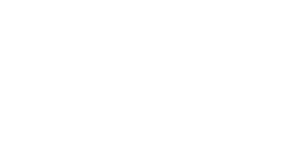

In [23]:
# Interactive 3D plot
%matplotlib notebook
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

ax.scatter3D(degrees['reciprocal'], degrees['only_in'], degrees['only_out'], c='red', s=2, label='nodes')

ax.set_xlim3d(0, max([max(degrees['reciprocal']), max(degrees['only_in']), max(degrees['only_out'])]))
ax.set_ylim3d(0, max([max(degrees['reciprocal']), max(degrees['only_in']), max(degrees['only_out'])]))
ax.set_zlim3d(0, max([max(degrees['reciprocal']), max(degrees['only_in']), max(degrees['only_out'])]))

ax.set_xlabel('reciprocal degree', fontsize=12)
ax.set_ylabel('in-degree', fontsize=12)
ax.set_zlabel('out-degree', fontsize=12)
ax.set_title('Node degrees in 3D space (equivalent axes)', fontsize=15)

plt.legend(prop={'size': 12})
plt.show()


### Draw the graph

Drawing bigger graphs can be time-consuming and the returned figure might not be easy to interpret.

In [24]:
# Color coding:
# - deg == 0: blue
# - deg <= mean: yellow
# - deg > mean: red
%matplotlib inline

if numNodes<=500:

    color_map = []
    for i in range(len(Graph.nodes)):
        if degrees['Ne'].iloc[i] == 0:
            color_map.append('blue')
        elif degrees['Ne'].iloc[i] <= np.mean(degrees['Ne']):
            color_map.append('yellow')
        else:
            color_map.append('red')

    # Plot as a figure
    fig = plt.figure(figsize=(20, 12))
    nx.draw_kamada_kawai(Graph, node_color=color_map, node_size=100, with_labels=True, font_size=5)
    plt.title('Network graph', fontsize=30)
    plt.show()
